# Investigating CW Attack Variants Using Diversity Promoting Regularization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import datetime
import glob
import os

import pickle

import pandas as pd
pd.set_option('display.max_rows', None)

%matplotlib inline

from models import *
from cw_div import *
from neuron_coverage import *
from inception_score import *
from fid_score import *

%load_ext autoreload
%autoreload 2

# check if CUDA is available
device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# load the results from file
with open('assets/results.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [3]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.manual_seed(random_seed)

In [4]:
#  torchvision.transforms.Normalize(
#    (0.1307,), (0.3081,))

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
    batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_test, shuffle=False, pin_memory=True)

# targets = true labels only for when you're doing a targeted attack
# otherwise, you're going to make the inputs easier to classify to 
# do a targeted attack, targets should be some class other than
# the true label

inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

# Train or Load Pretrained Model if available

In [5]:
retrain = False
track_low_high = False

model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# check to see if we can just load a previous model
# %mkdir models
latest_model = None
m_type = model.__class__.__name__
prev_models = glob.glob('pretrained_models/mnist/*'+ m_type +'*.pth')
if prev_models:
    latest_model = max(prev_models, key=os.path.getctime)

if (retrain is False 
    and latest_model is not None 
    and m_type in latest_model):  
    print('loading model', latest_model)
    model.load_state_dict(torch.load(latest_model))  
else:
    if track_low_high:
        model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
        try:
            for epoch in range(1, n_epochs + 1):
                model.hook_lowhigh_dict('relu')
                train(model, device, train_loader, optimizer, epoch)
                model.remove_hooks()
                test(model, device, test_loader)    
        finally:
            model.remove_hooks()   
    else:
        for epoch in range(1, n_epochs + 1):
            train(model, device, train_loader, optimizer, epoch)
            acc = test(model, device, test_loader)  
    torch.save(model.state_dict(), 'pretrained_models/mnist/model_' + m_type + '_' + str(datetime.datetime.now()).replace(':','.') + '_' + str(acc) + '.pth')

loading model pretrained_models/mnist\model_ConvNet_2019-07-25 16.16.26.580052_98.82.pth


# Attack Time

| Version | Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - | - |
|  Baseline CW | CW |  True | L2 |  L2 |
|  Diversity v1 | CW |  True | L2, Batch Divergence | Instance Divergence |
|  Diversity v2 | CW |  False | L2, Batch Divergence | Instance Divergence |
|  Diversity v3 | Cross Entropy |  False | L2, Batch Divergence | Instance Divergence |
|  Diversity v4 | CW |  True | L2, Batch Divergence | L2 |

In [6]:
targeted=False
confidence=0.0
c_range=(1e-3, 1e10)
search_steps=10
max_steps=1000
abort_early=True
optimizer_lr=5e-4

mean = (0.1307,) # the mean used in inputs normalization
std = (0.3081,) # the standard deviation used in inputs normalization
box = (min((0 - m) / s for m, s in zip(mean, std)),
       max((1 - m) / s for m, s in zip(mean, std)))

log_frequency = 100

In [7]:
layer_dict = get_model_modules(model)

## Baseline CW

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | L2 | L2 |

In [9]:
# cw_advs = cw_l2_attack(model, inputs, targets, device=device, targeted=False, 
#                        confidence=0.0, c_range=(1e-3, 1e10), search_steps=3, 
#                        max_steps=1000, abort_early=True, box=box, 
#                        optimizer_lr=5e-4, init_rand=False, log_frequency=100)

# print('made it out')
# eval_performance(model, inputs, cw_advs, targets)
# sample_1D_images(model, inputs, cw_advs, targets)

## Diversity Attack v1

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | Batch Divergence | Instance Divergence |

In [10]:
# cw_advs_div1 = cw_div1_attack(model, layer_dict['relu1-1'], 1, inputs, targets, device, 
#                               targeted=False, confidence=0.0, c_range=(1e-3, 1e10), 
#                               search_steps=3, max_steps=1000, abort_early=True, box=box,  
#                               optimizer_lr=5e-4, init_rand=False, log_frequency=100)

# eval_performance(model, inputs, cw_advs_div1, targets)
# sample_1D_images(model, inputs, cw_advs_div1, targets)

## Diversity Attack v2

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  False | Batch Divergence | Instance Divergence |

batch [0] loss: 898.3607177734375 cw_loss: 885.580322265625 L2_loss: 0.872971773147583 div_reg: 11.90739631652832
batch [100] loss: 671.103271484375 cw_loss: 611.6796875 L2_loss: 48.47657012939453 div_reg: 10.947005271911621
batch [200] loss: 541.894287109375 cw_loss: 417.7664489746094 L2_loss: 113.21733093261719 div_reg: 10.910508155822754
batch [300] loss: 461.7663879394531 cw_loss: 282.0042419433594 L2_loss: 168.8323516845703 div_reg: 10.929773330688477
batch [400] loss: 411.2378845214844 cw_loss: 192.668701171875 L2_loss: 207.60916137695312 div_reg: 10.960016250610352
batch [500] loss: 380.6635437011719 cw_loss: 139.6211395263672 L2_loss: 230.06263732910156 div_reg: 10.979767799377441
batch [600] loss: 360.6518859863281 cw_loss: 107.82527160644531 L2_loss: 241.83169555664062 div_reg: 10.994892120361328
batch [700] loss: 346.8420715332031 cw_loss: 87.94287109375 L2_loss: 247.89849853515625 div_reg: 11.000692367553711
batch [800] loss: 336.0551452636719 cw_loss: 73.5530776977539 L2_l

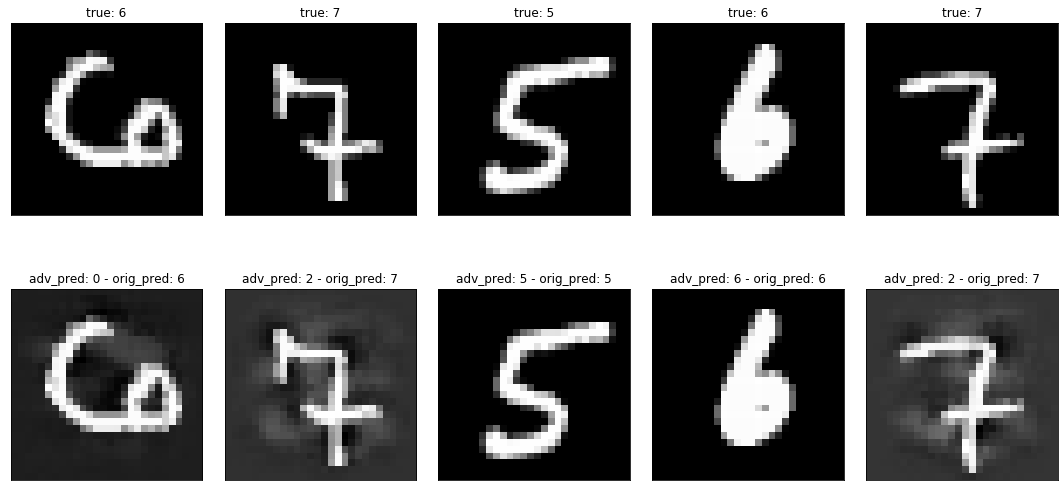

In [11]:
cw_advs_div2 = cw_div2_attack(model, layer_dict['relu1-1'], 1, inputs, targets, device, 
                              targeted=False, confidence=0.0, c_range=(1e-3, 1e10), 
                              search_steps=3, max_steps=1000, abort_early=True, box=box,  
                              optimizer_lr=5e-4, init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div2, targets)
sample_1D_images(model, inputs, cw_advs_div2, targets)

## Diversity Attack v3

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| Cross Entropy |  False | Batch Divergence | Instance Divergence |

In [11]:
# cw_advs_div3 = cw_div3_attack(model, layer_dict['relu1-1'], 1, inputs, targets, device, 
#                               targeted=False, confidence=0.0, c_range=(1e-3, 1e10), 
#                               search_steps=3, max_steps=1000, abort_early=True, box=box,  
#                               optimizer_lr=5e-4, init_rand=False, log_frequency=100)

# eval_performance(model, inputs, cw_advs_div3, targets)
# sample_1D_images(model, inputs, cw_advs_div3, targets)

## Diversity Attack v4

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| CW |  True | Batch Divergence | L2 |

In [ ]:
cw_advs_div4 = cw_div4_attack(model, layer_dict['relu1-1'], 1, inputs, targets, device, 
                              targeted=False, confidence=0.0, c_range=(1e-3, 1e10), 
                              search_steps=5, max_steps=1000, abort_early=True, box=box,  
                              optimizer_lr=5e-4, init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div4, targets)
sample_1D_images(model, inputs, cw_advs_div4, targets)

Step 0
batch [0] loss: 13.665948867797852 cw_loss: 0.8855803608894348 L2_loss: 0.872971773147583 div_reg: 11.90739631652832
batch [100] loss: 12.52118968963623 cw_loss: 0.8866482973098755 L2_loss: 0.46083131432533264 div_reg: 11.173709869384766
batch [200] loss: 12.39682388305664 cw_loss: 0.8876481056213379 L2_loss: 0.33473479747772217 div_reg: 11.17444133758545
batch [300] loss: 12.319329261779785 cw_loss: 0.8883450031280518 L2_loss: 0.25619450211524963 div_reg: 11.174789428710938
batch [400] loss: 12.266785621643066 cw_loss: 0.8888955116271973 L2_loss: 0.20274680852890015 div_reg: 11.175143241882324
batch [500] loss: 12.229269981384277 cw_loss: 0.8893411159515381 L2_loss: 0.1646054983139038 div_reg: 11.175323486328125
batch [600] loss: 12.201727867126465 cw_loss: 0.8897002935409546 L2_loss: 0.13613459467887878 div_reg: 11.17589282989502
batch [700] loss: 12.182663917541504 cw_loss: 0.8900155425071716 L2_loss: 0.11634622514247894 div_reg: 11.176301956176758
batch [800] loss: 12.167934

# Evaluation

In [ ]:
results = []
save_file_path = "assets/results_mnist2019.08.17.pickle"

# attack params
search_steps=10
targeted=False
c_range=(1e-3, 1e10)
max_steps=1000
abort_early=True
optimizer_lr=5e-4
init_rand=False
log_frequency = 100

mean = (0.1307,) # the mean used in inputs normalization
std = (0.3081,) # the standard deviation used in inputs normalization
box = (min((0 - m) / s for m, s in zip(mean, std)),
       max((1 - m) / s for m, s in zip(mean, std)))

n=2
attack_versions = [cw_div4_attack] # [cw_div1_attack, cw_div2_attack, cw_div3_attack, cw_div4_attack]
target_layers = list(layer_dict)[1::n]
reg_weights = [0, 1, 10, 100, 1000, 10000]
confidences = [0]

# neuron coverage params
nc_threshold = 0. # all activations are scaled to (0,1) after relu

# inception score (is) params
is_cuda = True
is_batch_size = 10
is_resize = True
is_splits = 10

# fréchet inception distance score (fid) params
real_path = "C:/temp_imgs/mnist/real/"
fake_path = "C:/temp_imgs/mnist/fake/"
fid_batch_size = 64
fid_cuda = True

if not os.path.exists(save_file_path):
    os.makedirs(save_file_path)

for attack in attack_versions:
    for layer_idx in target_layers:
        module = layer_dict[layer_idx]
        for rw in reg_weights:
            for c in confidences:
                
                timestamp = str(datetime.datetime.now()).replace(':','.')
                
                print('timestamp', timestamp, 
                      'attack', attack.__name__, 
                      'layer: ', layer_idx, 
                      'regularization_weight: ', rw, 
                      'confidence: ', c)
                
                # adversarial attack 
                adversaries = attack(model, module, rw, inputs, targets, device, targeted,
                                     c, c_range, search_steps, max_steps, abort_early, box,
                                     optimizer_lr, init_rand, log_frequency)
               
                # evaluate adversary effectiveness
                pert_acc, orig_acc = eval_performance(model, inputs, adversaries, targets)
                sample_1D_images(model, inputs, adversaries, targets)
                
                pert_acc = pert_acc.item() / 100.
                orig_acc = orig_acc.item() / 100.
                
                # neuron coverage
                covered_neurons, total_neurons, neuron_coverage_000 = eval_nc(model, adversaries, 0.00)
                print('neuron_coverage_000:', neuron_coverage_000)
                covered_neurons, total_neurons, neuron_coverage_020 = eval_nc(model, adversaries, 0.20)
                print('neuron_coverage_020:', neuron_coverage_020)
                covered_neurons, total_neurons, neuron_coverage_050 = eval_nc(model, adversaries, 0.50)
                print('neuron_coverage_050:', neuron_coverage_050)
                covered_neurons, total_neurons, neuron_coverage_075 = eval_nc(model, adversaries, 0.75)
                print('neuron_coverage_075:', neuron_coverage_075)
                
                # inception score
                preprocessed_advs = preprocess_1D_imgs(adversaries)
                mean_is, std_is = inception_score(preprocessed_advs, is_cuda, is_batch_size, is_resize, is_splits)
                print('inception_score:', mean_is)
                
                # fid score 
                paths = [real_path, fake_path]
                
                # dimensionality = 64
                target_num = 64
                generate_imgs(inputs, real_path, target_num)
                generate_imgs(adversaries, fake_path, target_num)
                fid_score_64 = calculate_fid_given_paths(paths, fid_batch_size, fid_cuda, dims=64)
                print('fid_score_64:', fid_score_64)
                
                # dimensionality = 2048
                target_num = 2048
                generate_imgs(inputs, real_path, target_num)
                generate_imgs(adversaries, fake_path, target_num)
                fid_score_2048 = calculate_fid_given_paths(paths, fid_batch_size, fid_cuda, dims=2048)
                print('fid_score_2048:', fid_score_2048)
                
                out = {'timestamp': timestamp, 
                       'attack': attack.__name__, 
                       'layer': layer_idx, 
                       'regularization_weight': rw, 
                       'confidence': c, 
                       'adversaries': adversaries,
                       'pert_acc':pert_acc, 
                       'orig_acc': orig_acc,
                       'neuron_coverage_000': neuron_coverage_000,
                       'neuron_coverage_020': neuron_coverage_020,
                       'neuron_coverage_050': neuron_coverage_050,
                       'neuron_coverage_075': neuron_coverage_075,
                       'inception_score': mean_is,
                       'fid_score_64': fid_score_64,
                       'fid_score_2048': fid_score_2048}
                
                results.append(out)
                
                # save incremental outputs
                pickle.dump(results, open(save_file_path, "wb"))

timestamp 2019-08-17 19.04.40.581612 attack cw_div4_attack layer:  relu1-1 regularization_weight:  0 confidence:  0
Step 0
batch [0] batch_loss: 1.662421464920044 cw_loss: 0.8633882403373718 L2_loss: 0.7990331649780273 div_reg: 0.0
batch [100] batch_loss: 1.2475180625915527 cw_loss: 0.8652935028076172 L2_loss: 0.38222450017929077 div_reg: 0.0
batch [200] batch_loss: 1.1365234851837158 cw_loss: 0.8662397861480713 L2_loss: 0.2702837586402893 div_reg: 0.0
batch [300] batch_loss: 1.0665966272354126 cw_loss: 0.8669042587280273 L2_loss: 0.19969241321086884 div_reg: 0.0
batch [400] batch_loss: 1.0185449123382568 cw_loss: 0.8674188852310181 L2_loss: 0.15112605690956116 div_reg: 0.0
batch [500] batch_loss: 0.9842644333839417 cw_loss: 0.8678358793258667 L2_loss: 0.11642854660749435 div_reg: 0.0
batch [600] batch_loss: 0.9592142105102539 cw_loss: 0.8681803941726685 L2_loss: 0.09103384613990784 div_reg: 0.0
batch [700] batch_loss: 0.940573513507843 cw_loss: 0.8684710264205933 L2_loss: 0.0721024870

timestamp 2019-08-06 01.49.14.849902 attack cw_div4_attack layer:  relu1-1 regularization_weight:  10 confidence:  40
Step 0
batch [0] loss: 124.82777404785156 cw_loss: 4.880842208862305 L2_loss: 0.872971773147583 div_reg: 119.07395935058594
batch [100] loss: 116.20146179199219 cw_loss: 4.88009786605835 L2_loss: 0.858628511428833 div_reg: 110.46273803710938
batch [200] loss: 116.08021545410156 cw_loss: 4.881077766418457 L2_loss: 0.7366853952407837 div_reg: 110.46245574951172
batch [300] loss: 116.00477600097656 cw_loss: 4.881723403930664 L2_loss: 0.6593384742736816 div_reg: 110.46371459960938
batch [400] loss: 115.9511489868164 cw_loss: 4.88224458694458 L2_loss: 0.6038746237754822 div_reg: 110.46502685546875
batch [500] loss: 115.91624450683594 cw_loss: 4.882668495178223 L2_loss: 0.5674556493759155 div_reg: 110.46611785888672
batch [600] loss: 115.8895034790039 cw_loss: 4.883022785186768 L2_loss: 0.5402083396911621 div_reg: 110.46627044677734
batch [700] loss: 115.86968994140625 cw_los

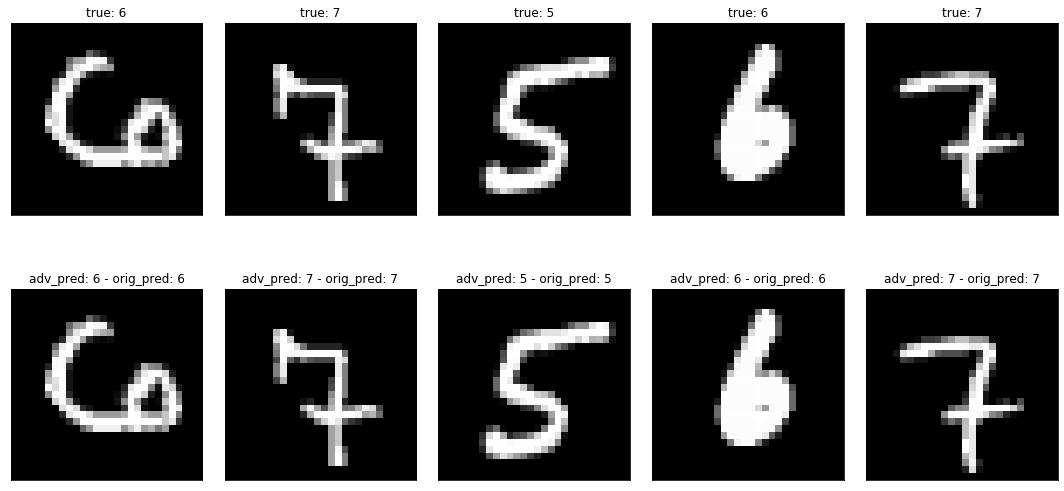

timestamp 2019-08-06 01.50.36.215980 attack cw_div4_attack layer:  relu1-1 regularization_weight:  10 confidence:  20
Step 0
batch [0] loss: 122.82777404785156 cw_loss: 2.880842447280884 L2_loss: 0.872971773147583 div_reg: 119.07395935058594
batch [100] loss: 114.2015151977539 cw_loss: 2.880096673965454 L2_loss: 0.8587047457695007 div_reg: 110.46271514892578
batch [200] loss: 114.07991790771484 cw_loss: 2.881074905395508 L2_loss: 0.7363764643669128 div_reg: 110.46246337890625
batch [300] loss: 114.00403594970703 cw_loss: 2.8817226886749268 L2_loss: 0.658520519733429 div_reg: 110.46379089355469
batch [400] loss: 113.9504623413086 cw_loss: 2.88224720954895 L2_loss: 0.603115439414978 div_reg: 110.46510314941406
batch [500] loss: 113.91522979736328 cw_loss: 2.8826754093170166 L2_loss: 0.5663309097290039 div_reg: 110.46622467041016
batch [600] loss: 113.88796997070312 cw_loss: 2.8830246925354004 L2_loss: 0.5388070344924927 div_reg: 110.46614074707031
batch [700] loss: 113.86795043945312 cw_

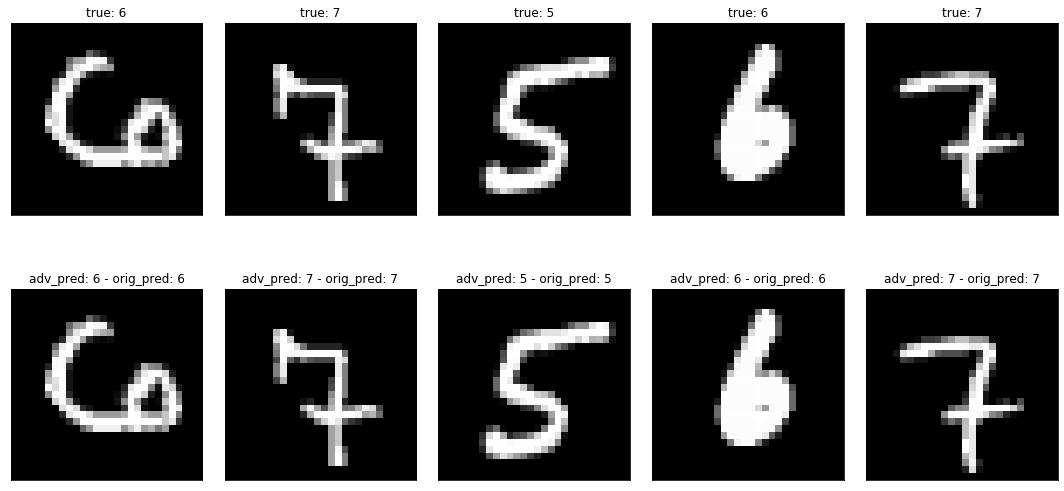

timestamp 2019-08-06 01.51.56.255874 attack cw_div4_attack layer:  relu1-1 regularization_weight:  10 confidence:  0
Step 0
batch [0] loss: 120.83251190185547 cw_loss: 0.8855803608894348 L2_loss: 0.872971773147583 div_reg: 119.07395935058594
batch [100] loss: 112.20582580566406 cw_loss: 0.8849272131919861 L2_loss: 0.8586720824241638 div_reg: 110.46222686767578
batch [200] loss: 112.08448791503906 cw_loss: 0.8859089612960815 L2_loss: 0.7366055250167847 div_reg: 110.46197509765625
batch [300] loss: 112.0087661743164 cw_loss: 0.88655686378479 L2_loss: 0.6589658856391907 div_reg: 110.46324157714844
batch [400] loss: 111.95514678955078 cw_loss: 0.8870831727981567 L2_loss: 0.6035112142562866 div_reg: 110.46455383300781
batch [500] loss: 111.91986083984375 cw_loss: 0.8875097632408142 L2_loss: 0.5678156614303589 div_reg: 110.46453857421875
batch [600] loss: 111.89289093017578 cw_loss: 0.8878573179244995 L2_loss: 0.5399117469787598 div_reg: 110.46511840820312
batch [700] loss: 111.8730697631836

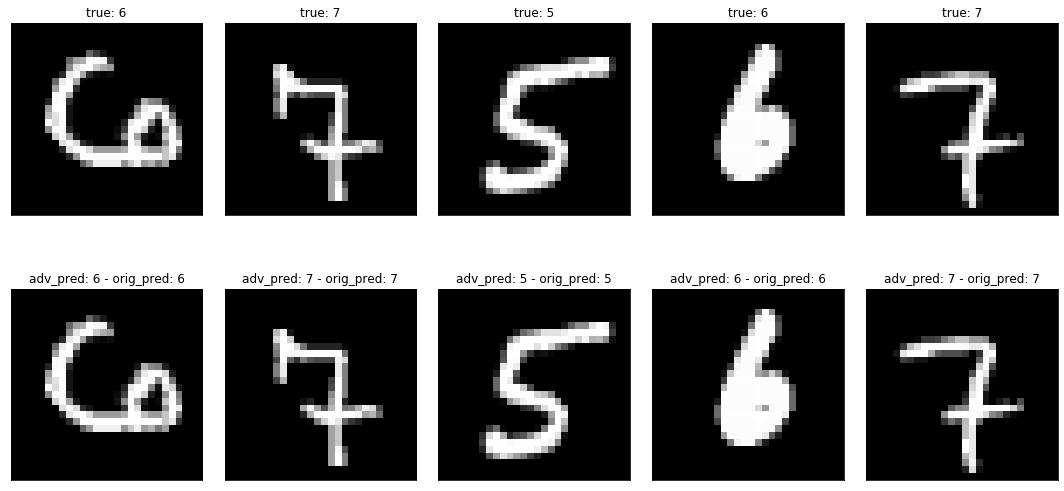

timestamp 2019-08-06 01.53.18.101908 attack cw_div4_attack layer:  relu1-1 regularization_weight:  1 confidence:  40
Step 0
batch [0] loss: 17.661209106445312 cw_loss: 4.880842208862305 L2_loss: 0.872971773147583 div_reg: 11.90739631652832
batch [100] loss: 16.51616668701172 cw_loss: 4.881800651550293 L2_loss: 0.46071097254753113 div_reg: 11.173654556274414
batch [200] loss: 16.391691207885742 cw_loss: 4.882817268371582 L2_loss: 0.33448055386543274 div_reg: 11.174392700195312
batch [300] loss: 16.313705444335938 cw_loss: 4.883517265319824 L2_loss: 0.2554304301738739 div_reg: 11.17475700378418
batch [400] loss: 16.261465072631836 cw_loss: 4.884058952331543 L2_loss: 0.20236265659332275 div_reg: 11.175043106079102
batch [500] loss: 16.223955154418945 cw_loss: 4.884505271911621 L2_loss: 0.16418446600437164 div_reg: 11.175265312194824
batch [600] loss: 16.196428298950195 cw_loss: 4.884861946105957 L2_loss: 0.13576826453208923 div_reg: 11.175798416137695
batch [700] loss: 16.177101135253906 

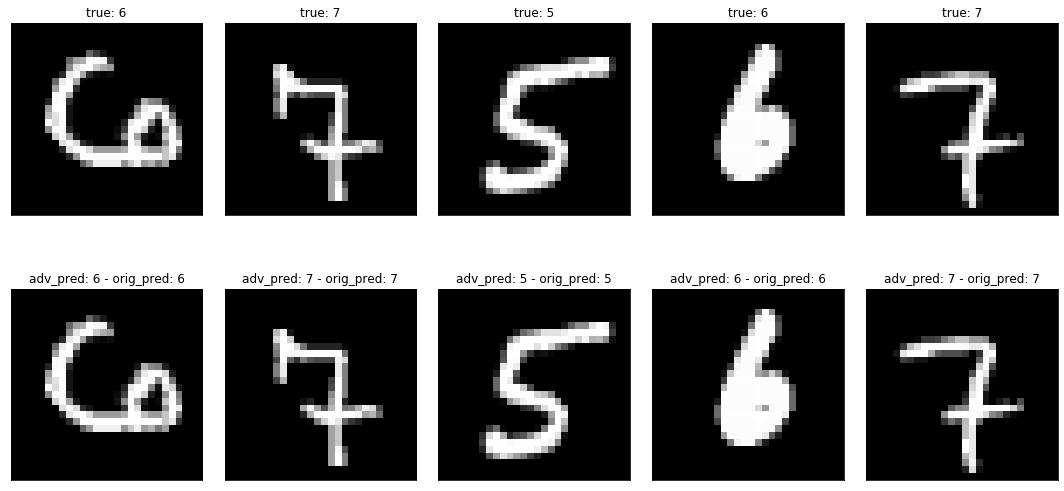

timestamp 2019-08-06 01.54.41.420081 attack cw_div4_attack layer:  relu1-1 regularization_weight:  1 confidence:  20
Step 0
batch [0] loss: 15.661211013793945 cw_loss: 2.880842447280884 L2_loss: 0.872971773147583 div_reg: 11.90739631652832
batch [100] loss: 14.516207695007324 cw_loss: 2.881804943084717 L2_loss: 0.46052151918411255 div_reg: 11.173881530761719
batch [200] loss: 14.392156600952148 cw_loss: 2.882814884185791 L2_loss: 0.33470475673675537 div_reg: 11.174636840820312
batch [300] loss: 14.314197540283203 cw_loss: 2.883514881134033 L2_loss: 0.2556686997413635 div_reg: 11.175013542175293
batch [400] loss: 14.261869430541992 cw_loss: 2.8840653896331787 L2_loss: 0.20248085260391235 div_reg: 11.175323486328125
batch [500] loss: 14.224743843078613 cw_loss: 2.8845083713531494 L2_loss: 0.16481265425682068 div_reg: 11.175422668457031
batch [600] loss: 14.197117805480957 cw_loss: 2.8848721981048584 L2_loss: 0.13611721992492676 div_reg: 11.176128387451172
batch [700] loss: 14.17842102050

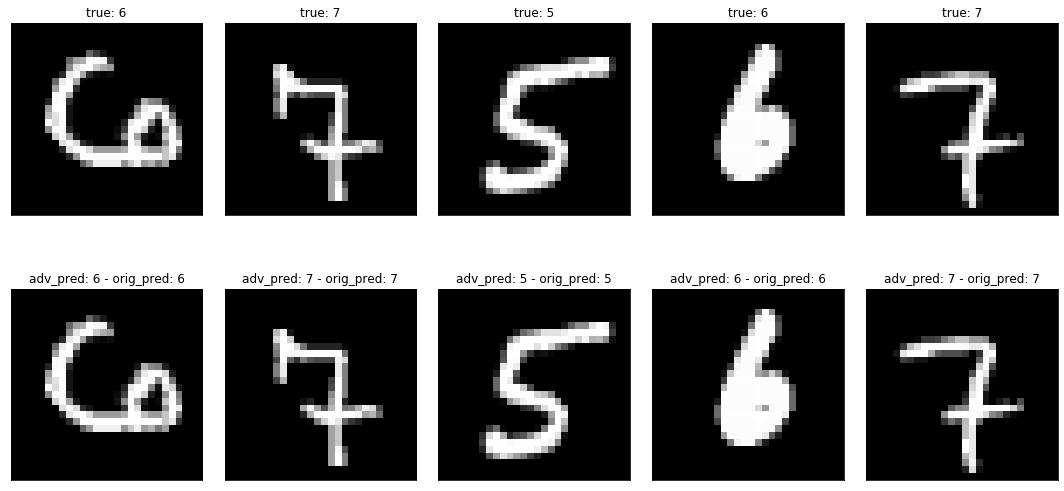

timestamp 2019-08-06 01.56.11.617841 attack cw_div4_attack layer:  relu1-1 regularization_weight:  1 confidence:  0
Step 0
batch [0] loss: 13.665948867797852 cw_loss: 0.8855803608894348 L2_loss: 0.872971773147583 div_reg: 11.90739631652832
batch [100] loss: 12.521080017089844 cw_loss: 0.8866467475891113 L2_loss: 0.4607312083244324 div_reg: 11.173702239990234
batch [200] loss: 12.396821975708008 cw_loss: 0.8876579403877258 L2_loss: 0.33470654487609863 div_reg: 11.174457550048828
batch [300] loss: 12.318943977355957 cw_loss: 0.8883568048477173 L2_loss: 0.25574782490730286 div_reg: 11.17483901977539
batch [400] loss: 12.266719818115234 cw_loss: 0.8889039158821106 L2_loss: 0.20272845029830933 div_reg: 11.175086975097656
batch [500] loss: 12.229118347167969 cw_loss: 0.8893527388572693 L2_loss: 0.16451804339885712 div_reg: 11.175247192382812
batch [600] loss: 12.201921463012695 cw_loss: 0.8897159099578857 L2_loss: 0.13634565472602844 div_reg: 11.175859451293945
batch [700] loss: 12.183070182

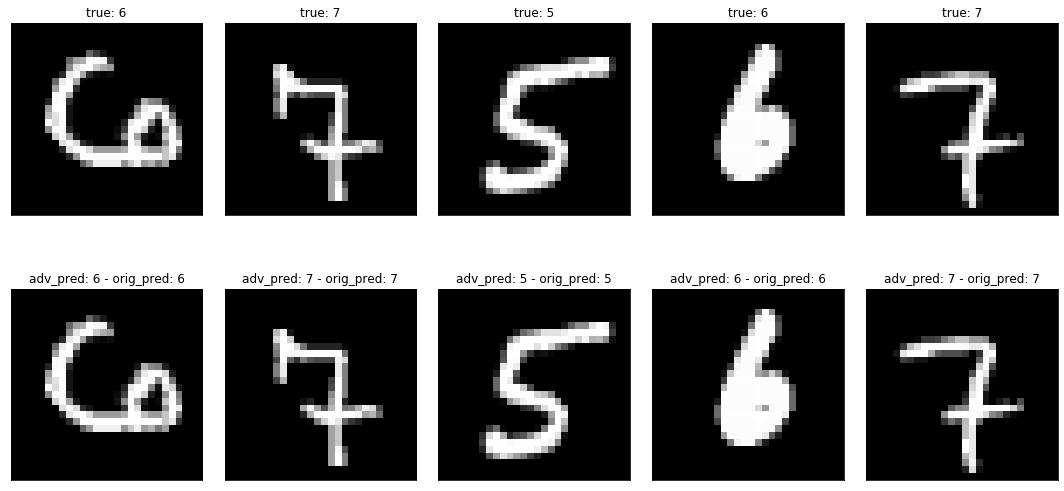

timestamp 2019-08-06 01.57.59.542049 attack cw_div4_attack layer:  relu1-1 regularization_weight:  0.01 confidence:  40
Step 0
batch [0] loss: 5.87288761138916 cw_loss: 4.880842208862305 L2_loss: 0.872971773147583 div_reg: 0.11907395720481873
batch [100] loss: 5.4234771728515625 cw_loss: 4.882233142852783 L2_loss: 0.4232986867427826 div_reg: 0.11794526129961014
batch [200] loss: 5.297961235046387 cw_loss: 4.883292198181152 L2_loss: 0.2966558337211609 div_reg: 0.11801329255104065
batch [300] loss: 5.219545364379883 cw_loss: 4.8839921951293945 L2_loss: 0.21747487783432007 div_reg: 0.11807825416326523
batch [400] loss: 5.166445732116699 cw_loss: 4.884560585021973 L2_loss: 0.16375890374183655 div_reg: 0.11812617629766464
batch [500] loss: 5.127643585205078 cw_loss: 4.885002136230469 L2_loss: 0.12455043941736221 div_reg: 0.1180909126996994
batch [600] loss: 5.103732585906982 cw_loss: 4.88536262512207 L2_loss: 0.10027305781841278 div_reg: 0.11809660494327545
batch [700] loss: 5.0823888778686

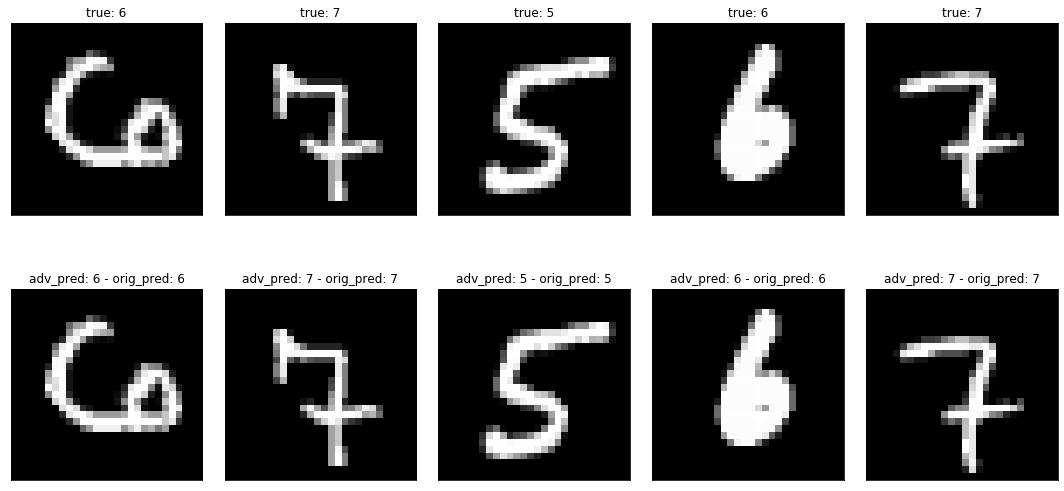

timestamp 2019-08-06 01.59.26.360769 attack cw_div4_attack layer:  relu1-1 regularization_weight:  0.01 confidence:  20
Step 0
batch [0] loss: 3.8728880882263184 cw_loss: 2.880842447280884 L2_loss: 0.872971773147583 div_reg: 0.11907395720481873
batch [100] loss: 3.4230422973632812 cw_loss: 2.8822760581970215 L2_loss: 0.42277342081069946 div_reg: 0.11799291521310806
batch [200] loss: 3.298813819885254 cw_loss: 2.8832833766937256 L2_loss: 0.29748085141181946 div_reg: 0.11804958432912827
batch [300] loss: 3.220074415206909 cw_loss: 2.884007453918457 L2_loss: 0.21798540651798248 div_reg: 0.11808158457279205
batch [400] loss: 3.167778253555298 cw_loss: 2.8845200538635254 L2_loss: 0.16515666246414185 div_reg: 0.11810159683227539
batch [500] loss: 3.1281797885894775 cw_loss: 2.884990692138672 L2_loss: 0.12502866983413696 div_reg: 0.11816056817770004
batch [600] loss: 3.1007118225097656 cw_loss: 2.8853671550750732 L2_loss: 0.0971432626247406 div_reg: 0.11820144206285477
batch [700] loss: 3.081

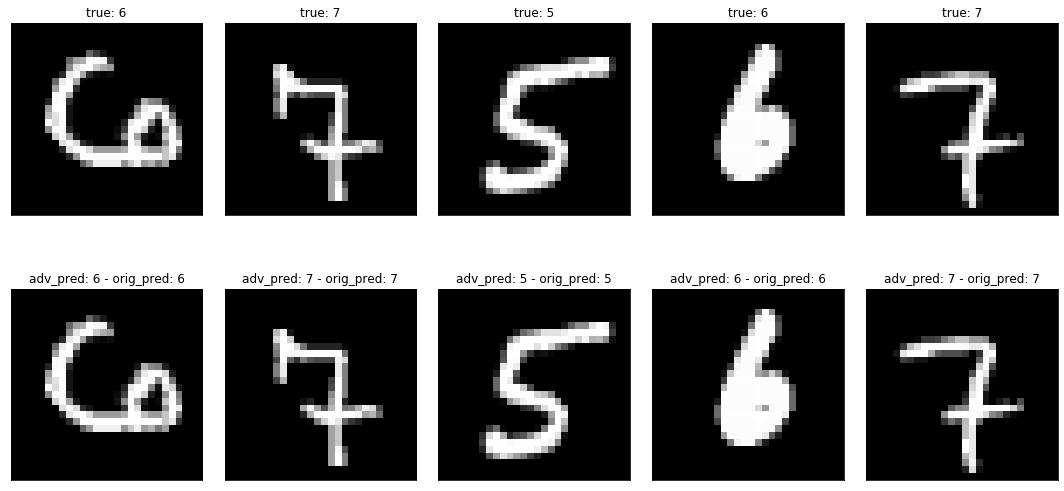

timestamp 2019-08-06 02.01.00.825612 attack cw_div4_attack layer:  relu1-1 regularization_weight:  0.01 confidence:  0
Step 0
batch [0] loss: 1.8776260614395142 cw_loss: 0.8855803608894348 L2_loss: 0.872971773147583 div_reg: 0.11907395720481873
batch [100] loss: 1.4282262325286865 cw_loss: 0.8871185183525085 L2_loss: 0.4231433868408203 div_reg: 0.11796430498361588
batch [200] loss: 1.3034776449203491 cw_loss: 0.8881243467330933 L2_loss: 0.2973891496658325 div_reg: 0.11796417832374573
batch [300] loss: 1.2263129949569702 cw_loss: 0.8888286352157593 L2_loss: 0.21947140991687775 div_reg: 0.1180129200220108
batch [400] loss: 1.1709997653961182 cw_loss: 0.8894098997116089 L2_loss: 0.16353385150432587 div_reg: 0.11805599927902222
batch [500] loss: 1.134301781654358 cw_loss: 0.889824390411377 L2_loss: 0.12640736997127533 div_reg: 0.11806996166706085
batch [600] loss: 1.1057865619659424 cw_loss: 0.8902125954627991 L2_loss: 0.09741158783435822 div_reg: 0.11816239356994629
batch [700] loss: 1.08

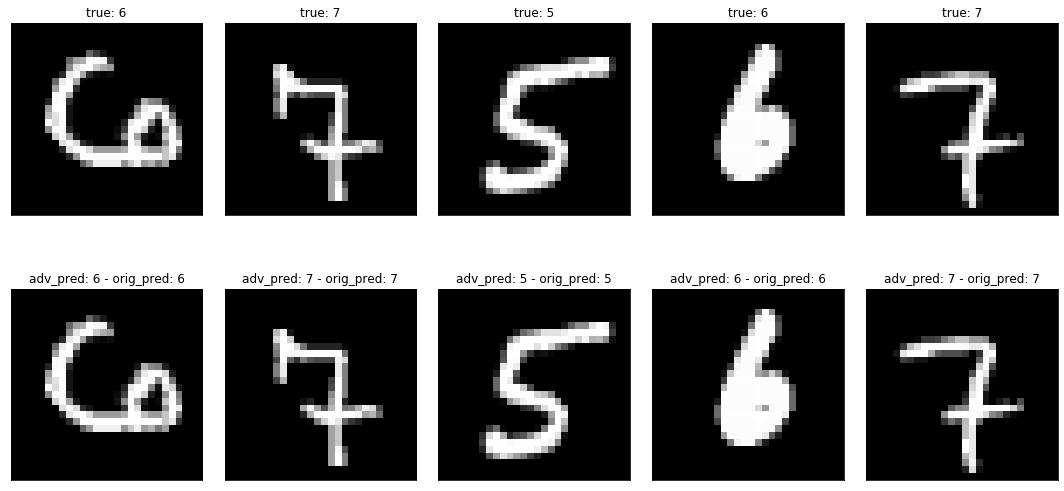

timestamp 2019-08-06 02.02.53.234614 attack cw_div4_attack layer:  relu1-1 regularization_weight:  0 confidence:  40
Step 0
batch [0] loss: 5.753813743591309 cw_loss: 4.880842208862305 L2_loss: 0.872971773147583 div_reg: 0.0
batch [100] loss: 5.303243637084961 cw_loss: 4.882423400878906 L2_loss: 0.4208201766014099 div_reg: 0.0
batch [200] loss: 5.178171634674072 cw_loss: 4.883432388305664 L2_loss: 0.29473909735679626 div_reg: 0.0
batch [300] loss: 5.099795341491699 cw_loss: 4.884137153625488 L2_loss: 0.21565841138362885 div_reg: 0.0
batch [400] loss: 5.046382427215576 cw_loss: 4.884682655334473 L2_loss: 0.16169974207878113 div_reg: 0.0
batch [500] loss: 5.008594989776611 cw_loss: 4.8851213455200195 L2_loss: 0.12347346544265747 div_reg: 0.0
batch [600] loss: 4.981208324432373 cw_loss: 4.885483264923096 L2_loss: 0.09572499245405197 div_reg: 0.0
batch [700] loss: 4.96099853515625 cw_loss: 4.885785102844238 L2_loss: 0.07521330565214157 div_reg: 0.0
batch [800] loss: 4.945864677429199 cw_lo

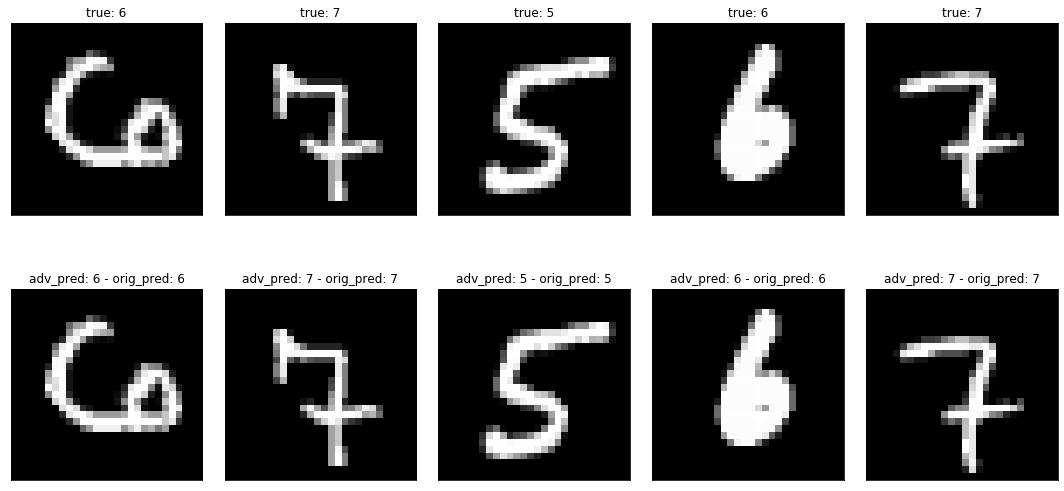

timestamp 2019-08-06 02.04.20.050845 attack cw_div4_attack layer:  relu1-1 regularization_weight:  0 confidence:  20
Step 0
batch [0] loss: 3.753814220428467 cw_loss: 2.880842447280884 L2_loss: 0.872971773147583 div_reg: 0.0
batch [100] loss: 3.303243637084961 cw_loss: 2.8824234008789062 L2_loss: 0.4208201766014099 div_reg: 0.0
batch [200] loss: 3.178171157836914 cw_loss: 2.883431911468506 L2_loss: 0.29473915696144104 div_reg: 0.0
batch [300] loss: 3.0997955799102783 cw_loss: 2.8841371536254883 L2_loss: 0.21565836668014526 div_reg: 0.0
batch [400] loss: 3.046382427215576 cw_loss: 2.8846826553344727 L2_loss: 0.16169968247413635 div_reg: 0.0
batch [500] loss: 3.008594512939453 cw_loss: 2.8851211071014404 L2_loss: 0.12347333133220673 div_reg: 0.0
batch [600] loss: 2.981207847595215 cw_loss: 2.8854830265045166 L2_loss: 0.09572494029998779 div_reg: 0.0
batch [700] loss: 2.96099853515625 cw_loss: 2.8857851028442383 L2_loss: 0.07521341741085052 div_reg: 0.0
batch [800] loss: 2.945865154266357

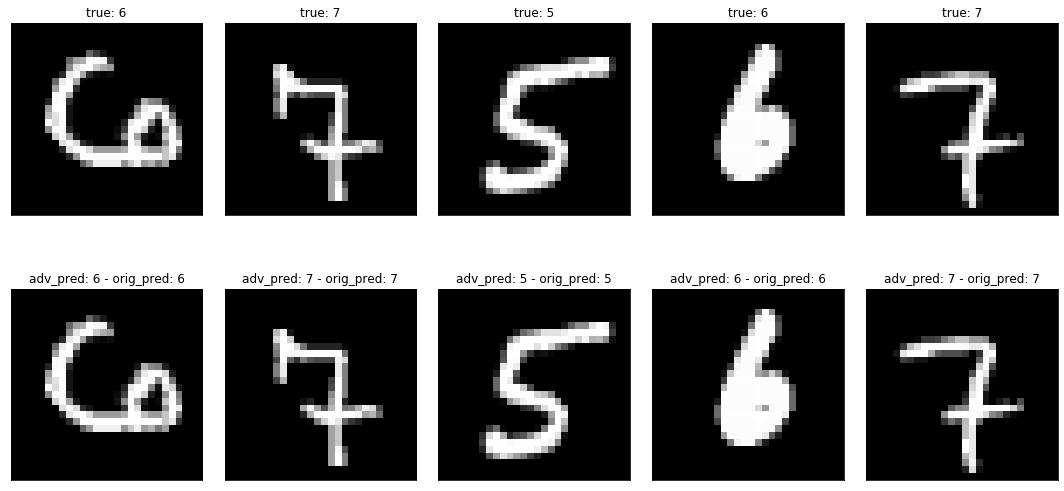

timestamp 2019-08-06 02.05.54.139997 attack cw_div4_attack layer:  relu1-1 regularization_weight:  0 confidence:  0
Step 0
batch [0] loss: 1.758552074432373 cw_loss: 0.8855803608894348 L2_loss: 0.872971773147583 div_reg: 0.0
batch [100] loss: 1.308068871498108 cw_loss: 0.8872683048248291 L2_loss: 0.4208005666732788 div_reg: 0.0
batch [200] loss: 1.1829969882965088 cw_loss: 0.8882800340652466 L2_loss: 0.2947169244289398 div_reg: 0.0
batch [300] loss: 1.1046209335327148 cw_loss: 0.8889862895011902 L2_loss: 0.21563464403152466 div_reg: 0.0
batch [400] loss: 1.0512070655822754 cw_loss: 0.8895318508148193 L2_loss: 0.16167527437210083 div_reg: 0.0
batch [500] loss: 1.0134187936782837 cw_loss: 0.8899707198143005 L2_loss: 0.12344806641340256 div_reg: 0.0
batch [600] loss: 0.9860315918922424 cw_loss: 0.8903326988220215 L2_loss: 0.09569891542196274 div_reg: 0.0
batch [700] loss: 0.9658211469650269 cw_loss: 0.8906346559524536 L2_loss: 0.07518652081489563 div_reg: 0.0
batch [800] loss: 0.950686991

In [ ]:
results = []
n=2

attack_versions = [cw_div4_attack] #[cw_div1_attack, cw_div2_attack, cw_div3_attack, cw_div4_attack]
target_layers = list(layer_dict)[1::n]
reg_weights = [0, 1, 10, 100, 1000, 10000]
confidences = [0]

attack_versions.reverse()
reg_weights.reverse()
confidences.reverse()

for attack in attack_versions:
    for layer_idx in target_layers:
        module = layer_dict[layer_idx]
        for rw in reg_weights:
            for c in confidences:
                
                timestamp = str(datetime.datetime.now()).replace(':','.')
                
                print('timestamp', timestamp, 
                      'attack', attack.__name__, 
                      'layer: ', layer_idx, 
                      'regularization_weight: ', rw, 
                      'confidence: ', c)
                
                cw_advs_divs = attack(model, module, rw, inputs, targets, device=device, targeted=False, confidence=c,
                                      c_range=(1e-3, 1e10), search_steps=3, max_steps=1000, 
                                      abort_early=True, box=box, optimizer_lr=5e-4, 
                                      init_rand=False, log_frequency=100)

                pert_acc, orig_acc = eval_performance(model, inputs, cw_advs_divs, targets)
                sample_1D_images(model, inputs, cw_advs_divs, targets)

                pert_acc = pert_acc.item() / 100.
                orig_acc = orig_acc.item() / 100.

                out = {'timestamp': timestamp, 
                       'attack': attack.__name__, 
                       'layer': layer_idx, 
                       'regularization_weight': rw, 
                       'confidence': c, 
                       'adversaries': cw_advs_divs,
                       'pert_acc':pert_acc, 
                       'orig_acc': orig_acc}
                
                results.append(out)
                
                pickle.dump(results, open( "assets/results_mnist.pickle", "wb" ))

In [15]:
df = pd.DataFrame.from_dict(results)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc']]

KeyboardInterrupt: 

In [16]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results.pickle", "wb" ))

In [17]:
# load the results from file
with open('assets/results.pickle', 'rb') as handle:
    results = pickle.load(handle)

# Coverage Criteria

## Neuron Coverage (DeepXplore)

In [30]:
def get_layer_output_sizes(model, data):   
    output_sizes = {}
    hooks = []  
    layers = list(dict(model.named_children()))   
    def hook(module, input, output):
        module_idx = len(output_sizes)
        m_key = layers[module_idx]
        output_sizes[m_key] = list(output.size()[1:])      
    for name, module in model.named_children():
        if (not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)):
            hooks.append(module.register_forward_hook(hook))
    try:
        out = model(data[:1])  
    finally:
        for h in hooks:
            h.remove()       
    return output_sizes

def get_init_dict(model, data, init_value=False): 
    output_sizes = get_layer_output_sizes(model, data)       
    model_layer_dict = {}  
    for layer, output_size in output_sizes.items():
        for index in range(np.prod(output_size)):
            # since we only care about post-activation outputs
            if 'relu' in layer.lower():
                model_layer_dict[(layer, index)] = init_value               
    return model_layer_dict

def neurons_covered(model_layer_dict):
    covered_neurons = len([v for v in model_layer_dict.values() if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)

def scale(out, rmax=1, rmin=0):
    output_std = (out - out.min()) / (out.max() - out.min())
    output_scaled = output_std * (rmax - rmin) + rmin
    return output_scaled

def update_coverage(model, data, model_layer_dict, threshold=0.):   
    layers = list(set([x[0] for x in list(model_layer_dict.keys())]))    
    for layer in layers:       
        outputs = torch.squeeze(model.extract_outputs(data, layer))
        scaled_outputs = scale(outputs)            
        for i, out in enumerate(scaled_outputs.view(-1)):
            if out > threshold:
                model_layer_dict[(layer, i)] = True
                
def eval_nc(model, data, threshold=0.):
    model_layer_dict = get_init_dict(model, data, False)
    update_coverage(model, data, model_layer_dict, threshold=threshold)
    _, _, nc = neurons_covered(model_layer_dict)
    return nc

In [32]:
# test baseline (unperturbed) inputs
for t in np.linspace(0, 1, 10):
    print('threshold:', t, eval_nc(model, inputs, threshold=t))

threshold: 0.0 0.6015768725361367
threshold: 0.1111111111111111 0.1795663600525624
threshold: 0.2222222222222222 0.1038107752956636
threshold: 0.3333333333333333 0.06399474375821287
threshold: 0.4444444444444444 0.042378449408672796
threshold: 0.5555555555555556 0.026675427069645204
threshold: 0.6666666666666666 0.01392904073587385
threshold: 0.7777777777777777 0.006176084099868594
threshold: 0.8888888888888888 0.0021681997371879105
threshold: 1.0 0.0


In [25]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    nc = eval_nc(model, results[i]['adversaries'], threshold=0.)
    results[i]['neuron_coverage'] = nc
    print(i, a, l, rw, nc) 

0 cw_div1_attack relu1 0 0.5850197109067017
1 cw_div1_attack relu1 0.001 0.5576215505913272
2 cw_div1_attack relu1 0.01 0.4885676741130092
3 cw_div1_attack relu1 1 0.43495400788436267
4 cw_div1_attack relu1 10 0.585611038107753
5 cw_div1_attack relu1 100 0.585611038107753
6 cw_div1_attack relu2 0 0.5851511169513798
7 cw_div1_attack relu2 0.001 0.5846911957950066
8 cw_div1_attack relu2 0.01 0.5894875164257556
9 cw_div1_attack relu2 1 0.5682654402102497
10 cw_div1_attack relu2 10 0.5706964520367936
11 cw_div1_attack relu2 100 0.5704993429697766
12 cw_div1_attack relu3 0 0.5850197109067017
13 cw_div1_attack relu3 0.001 0.5851511169513798
14 cw_div1_attack relu3 0.01 0.5850197109067017
15 cw_div1_attack relu3 1 0.5851511169513798
16 cw_div1_attack relu3 10 0.5854139290407359
17 cw_div1_attack relu3 100 0.5849540078843627
18 cw_div2_attack relu1 0 0.5852825229960578
19 cw_div2_attack relu1 0.001 0.5838370565045992
20 cw_div2_attack relu1 0.01 0.5883048620236531
21 cw_div2_attack relu1 1 0.6

In [19]:
df = pd.DataFrame.from_dict(results)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc', 'neuron_coverage']]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage
0,cw_div1_attack,relu1,0,0.98,0.00,0.585020
1,cw_div1_attack,relu1,0.001,0.98,0.00,0.557622
2,cw_div1_attack,relu1,0.01,0.98,0.00,0.488568
3,cw_div1_attack,relu1,1,0.98,0.00,0.434954
4,cw_div1_attack,relu1,10,0.98,0.01,0.585611
5,cw_div1_attack,relu1,100,0.98,0.01,0.585611
6,cw_div1_attack,relu2,0,0.98,0.00,0.585151
7,cw_div1_attack,relu2,0.001,0.98,0.00,0.584691
8,cw_div1_attack,relu2,0.01,0.98,0.00,0.589488
9,cw_div1_attack,relu2,1,0.98,0.00,0.568265


In [76]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results.pickle", "wb" ))

## k-multisection Neuron Coverage (DeepGauge)

In [13]:
# model.init_dict(model.covered_dict, inputs, 'relu', False)
# model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
# print(len(model.covered_dict), len(model.lowhigh_dict))

In [9]:
# # move this to cpu because the GPU RAM probably isn't large enough to handle it 
# device = torch.device("cpu")
# model.to(device)

model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
model.hook_lowhigh_dict('relu')

lohi_batch_size = int(len(train_loader.dataset) / 10)

lowhigh_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
    batch_size=lohi_batch_size, shuffle=True, pin_memory=True)

for i, (lohi_inputs, _) in enumerate(lowhigh_loader):
    print('batch:', i)
    lohi_inputs = lohi_inputs.to(device)
    model(lohi_inputs)

model.remove_hooks()

# device = torch.device("cuda")

pickle.dump(model.lowhigh_dict, open( "assets/lowhigh_dict.pickle", "wb" ))

{('relu1', 0): {'low': 0, 'high': 0.17005696892738342},
 ('relu1', 1): {'low': 0, 'high': 0.2610016167163849},
 ('relu1', 2): {'low': 0, 'high': 0.3574622869491577},
 ('relu1', 3): {'low': 0, 'high': 0.4250221848487854},
 ('relu1', 4): {'low': 0, 'high': 0.4433531165122986},
 ('relu1', 5): {'low': 0, 'high': 0.42099499702453613},
 ('relu1', 6): {'low': 0, 'high': 0.3878710865974426},
 ('relu1', 7): {'low': 0, 'high': 0.4209814667701721},
 ('relu1', 8): {'low': 0, 'high': 0.42347657680511475},
 ('relu1', 9): {'low': 0, 'high': 0.40517371892929077},
 ('relu1', 10): {'low': 0, 'high': 0.7064920663833618},
 ('relu1', 11): {'low': 0, 'high': 0.8078417778015137},
 ('relu1', 12): {'low': 0, 'high': 0.6157643795013428},
 ('relu1', 13): {'low': 0, 'high': 0.47518014907836914},
 ('relu1', 14): {'low': 0, 'high': 0.3899363875389099},
 ('relu1', 15): {'low': 0, 'high': 0.3532407879829407},
 ('relu1', 16): {'low': 0, 'high': 0.3282723128795624},
 ('relu1', 17): {'low': 0, 'high': 0.3503431081771850

In [5]:
# load the results from file
with open('assets/lowhigh_dict.pickle', 'rb') as handle:
    model.lowhigh_dict = pickle.load(handle)

In [6]:
get_dict_for_layer(model.lowhigh_dict, 'relu3')

{('relu3', 0): {'low': 0, 'high': 4.8202948570251465},
 ('relu3', 1): {'low': 0, 'high': 4.82769775390625},
 ('relu3', 2): {'low': 0, 'high': 7.479001522064209},
 ('relu3', 3): {'low': 0, 'high': 8.612505912780762},
 ('relu3', 4): {'low': 0, 'high': 5.791659355163574},
 ('relu3', 5): {'low': 0, 'high': 7.655079364776611},
 ('relu3', 6): {'low': 0, 'high': 6.207518100738525},
 ('relu3', 7): {'low': 0, 'high': 7.808154582977295},
 ('relu3', 8): {'low': 0, 'high': 8.590152740478516},
 ('relu3', 9): {'low': 0, 'high': 2.782480001449585},
 ('relu3', 10): {'low': 0, 'high': 1.412194848060608},
 ('relu3', 11): {'low': 0, 'high': 6.954821586608887},
 ('relu3', 12): {'low': 0, 'high': 4.98781681060791},
 ('relu3', 13): {'low': 0, 'high': 1.674249291419983},
 ('relu3', 14): {'low': 0, 'high': 3.0363736152648926},
 ('relu3', 15): {'low': 0, 'high': 5.852689743041992},
 ('relu3', 16): {'low': 0, 'high': 7.916790962219238},
 ('relu3', 17): {'low': 0, 'high': 6.889847755432129},
 ('relu3', 18): {'lo

# Inception Scoring

In [21]:
from inception_score import *
# %load_ext autoreload
# %autoreload 2

In [22]:
def preprocess_for_is(imgs):
    '''
    imgs : input expected to be a pytorch cuda tensor of images with a single dimension
    returns the input images as a 3D numpy array by replicating the single array 3 times
    '''
    adv_np = imgs.cpu().detach().numpy()
    adv_3d = np.tile(adv_np[..., None], 3)
    adv_3d = np.transpose(adv_3d, (0, 4, 2, 3, 1))
    adv_3d = np.squeeze(adv_3d)
    return adv_3d

In [18]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    adv_3d = preprocess_for_is(results[i]['adversaries'])
    mean_is, std_is = inception_score(adv_3d, cuda=True, batch_size=10, resize=True, splits=10)
    results[i]['inception_score'] = mean_is
    print(i, a, l, rw, mean_is) 

0 cw_div1_attack relu1 0 2.1209492815586906
1 cw_div1_attack relu1 0.001 2.127311732225868
2 cw_div1_attack relu1 0.01 2.1292338489015177
3 cw_div1_attack relu1 1 2.1406525736513213
4 cw_div1_attack relu1 10 2.1289341141537674
5 cw_div1_attack relu1 100 2.129162888722381
6 cw_div1_attack relu2 0 2.121341867838196
7 cw_div1_attack relu2 0.001 2.1283085506669894
8 cw_div1_attack relu2 0.01 2.128306204108593
9 cw_div1_attack relu2 1 2.156900076796944
10 cw_div1_attack relu2 10 2.160886621290113
11 cw_div1_attack relu2 100 2.16015964869021
12 cw_div1_attack relu3 0 2.1206074935563985
13 cw_div1_attack relu3 0.001 2.1211123572604844
14 cw_div1_attack relu3 0.01 2.1215065538287528
15 cw_div1_attack relu3 1 2.121403170482811
16 cw_div1_attack relu3 10 2.1203692489550567
17 cw_div1_attack relu3 100 2.1208818906729934
18 cw_div2_attack relu1 0 2.150741244827747
19 cw_div2_attack relu1 0.001 2.1565648058678675
20 cw_div2_attack relu1 0.01 2.1564078357085883
21 cw_div2_attack relu1 1 2.1597769637

In [23]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc', 'inception_score']]

,attack,layer,regularization_weight,orig_acc,pert_acc,inception_score
0,cw_div1_attack,relu1,0.000,0.98,0.00,2.120949
1,cw_div1_attack,relu1,0.001,0.98,0.00,2.127312
2,cw_div1_attack,relu1,0.010,0.98,0.00,2.129234
3,cw_div1_attack,relu1,1.000,0.98,0.00,2.140653
4,cw_div1_attack,relu1,10.000,0.98,0.01,2.128934
5,cw_div1_attack,relu1,100.000,0.98,0.01,2.129163
6,cw_div1_attack,relu2,0.000,0.98,0.00,2.121342
7,cw_div1_attack,relu2,0.001,0.98,0.00,2.128309
8,cw_div1_attack,relu2,0.010,0.98,0.00,2.128306
9,cw_div1_attack,relu2,1.000,0.98,0.00,2.156900


In [30]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results.pickle", "wb" ))

In [20]:
# plt.imshow(adv_np[0].reshape(28, 28))
# plt.imshow(adv_3d[0].transpose((1,2,0)))

# Fréchet Inception Distance (FID) Scoring
https://github.com/mseitzer/pytorch-fid

In [10]:
batch_size_FID = 2048

FID_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_FID, shuffle=True, pin_memory=True)

# targets = true labels only for when you're doing a targeted attack
# otherwise, you're going to make the inputs easier to classify to 
# do a targeted attack, targets should be some class other than
# the true label

inputs_fid, targets_fid = next(iter(FID_loader))

inputs_fid = inputs_fid.to(device)
targets_fid = targets_fid.to(device)

In [11]:
img_root = "temp_imgs/"
img_dirs = ["real/", "fake/"]

for img_dir in img_dirs:
    target_dir = img_root + img_dir
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        for i, (img, lbl) in enumerate(zip(inputs_fid, targets_fid)):
            filename = target_dir + "img_" + str(i) + "_" + str(lbl.item()) + ".png"
            torchvision.utils.save_image(img, filename)

In [ ]:
# # run this in cmd line
# !python fid_score.py temp_imgs/real temp_imgs/fake

# starting calculate_fid_given_paths()...
# starting _compute_statistics_of_path()...
# starting calculate_activation_statistics()...
# starting get_activations()...
# starting _compute_statistics_of_path()...
# starting calculate_activation_statistics()...
# starting get_activations()...
# starting calculate_frechet_distance()...
# FID:  -4.0333336670528297e-10

[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 434, in superreload
    module = reload(module)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\imp.py", line 314, in reload
    """
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\

[autoreload of runpy failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 280, in update_instances
   

[autoreload of collections.abc failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 280, in update_ins

[autoreload of ast failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 280, in update_instances
    f

[autoreload of ctypes failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 280, in update_instances
  

[autoreload of IPython.core.interactiveshell failed: Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\extensions\autoreload.py", line 434, in superreload
    module = reload(module)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\imp.py", line 314, in reload
    """
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\importlib\__init__.py", line 169, in reload
    finally:
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\Fabrice\AppData\Local\Continuu

Traceback (most recent call last):
Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x0000023D8827F2F0> (for post_run_cell):
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    try:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 3001, in run_cell_async
    with self.builtin_trap:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\compilerop.py", line 135, in cache
    linecache._ipython_cache[name] = entry
AttributeError: module 'linecache' has no attribute '_ipython_cache'

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    try:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 3001, in run_cell_async
    with self.builtin_trap:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\compilerop.py", line 135, in cache
    linecache._ipython_cache[name] = entry
AttributeError: module 'linecache' has no attribute '_ipython_cache'

During handling of the above exce

Future exception was never retrieved
future: <Future finished exception=TypeError('can only concatenate str (not "list") to str')>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    try:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\interactiveshell.py", line 3001, in run_cell_async
    with self.builtin_trap:
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\summer19_research\lib\site-packages\IPython\core\compilerop.py", line 135, in cache
    linecache._ipython_cache[name] = entry
AttributeError: module 'linecache' has no attribute '_ipython_cache'

During handling of the above 